# K-Means Banknote dataset

In [64]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from scipy.stats import mode
import numpy as np
from sklearn.metrics import silhouette_score



In [65]:
RANDOM_SEED = 4
DATASPLIT = 0.3
DATASET_ID= 267

In [66]:
logger = logging.getLogger(str(DATASET_ID))
logging.basicConfig(level=logging.DEBUG)

In [67]:
dataset = fetch_ucirepo(id=DATASET_ID)

df = pd.DataFrame(dataset.data.features)

label_encoder = LabelEncoder()

df['class'] = label_encoder.fit_transform(dataset.data.targets)

df = df.replace("?", pd.NA).dropna()

scaler = StandardScaler()

data = scaler.fit_transform(df)

labels = df['class']

df = df.drop(columns=['class'])



data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size=DATASPLIT, random_state=RANDOM_SEED)
data_train, data_val, label_train, label_val = train_test_split(data_train, label_train, test_size=DATASPLIT, random_state=RANDOM_SEED)

logger.info(f"Train dataset length: {len(data_train)}, Validation dataset length: {len(data_val)}, Test dataset length: {len(data_test)}")

print(df.head())




c:\Users\Santiago\Desktop\Miniproject\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:267:Train dataset length: 672, Validation dataset length: 288, Test dataset length: 412


   variance  skewness  curtosis  entropy
0   3.62160    8.6661   -2.8073 -0.44699
1   4.54590    8.1674   -2.4586 -1.46210
2   3.86600   -2.6383    1.9242  0.10645
3   3.45660    9.5228   -4.0112 -3.59440
4   0.32924   -4.4552    4.5718 -0.98880


In [68]:
parameters = {
    'n_clusters': range(2, 10, 1),
    'max_iter': range(100, 500, 100),
}


clf = GridSearchCV(KMeans(random_state=RANDOM_SEED), parameters, scoring='accuracy', verbose=0)
clf.fit(data_val, label_val)

model = clf.best_estimator_
logger.info("Best cross-validation score: %f", clf.best_score_)
logger.info("With parameters: %s", clf.best_params_)

logger.info("Training model with best parameters")
model.fit(data_train, label_train)

predictions = model.predict(data_test)

   
mapped_labels = np.zeros_like(predictions)
for i in range(clf.best_params_['n_clusters']):  
    mask = (predictions == i)
    mapped_labels[mask] = mode(label_test[mask])[0]



accuracy = accuracy_score(label_test, mapped_labels)
logger.info("Accuracy: %f", accuracy)

f1 = f1_score(label_test, mapped_labels, average='weighted')
logger.info("F1 score: %f", f1)

ari = adjusted_rand_score(label_test, mapped_labels)
logger.info("ARI score: %f", ari)

sil = silhouette_score(data_test, mapped_labels)
logger.info("Silhouette score: %f", sil)



INFO:267:Best cross-validation score: 0.489716
INFO:267:With parameters: {'max_iter': 100, 'n_clusters': 2}
INFO:267:Training model with best parameters
INFO:267:Accuracy: 0.995146
INFO:267:F1 score: 0.995149
INFO:267:ARI score: 0.980626
INFO:267:Silhouette score: 0.361251


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000297C8417BF0>


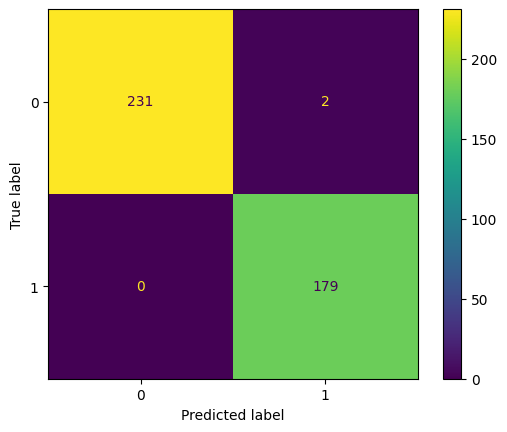

In [69]:
cm = confusion_matrix(label_test, mapped_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()


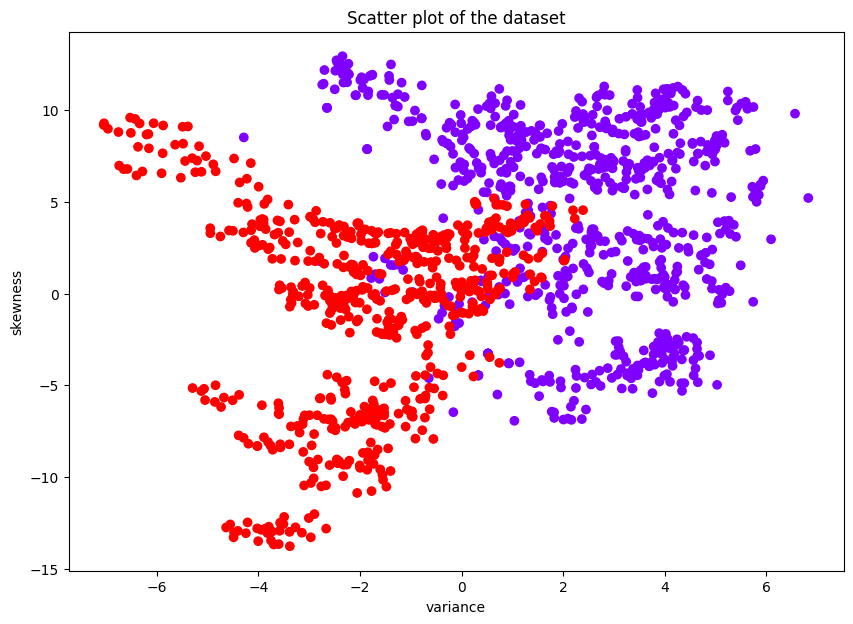

In [70]:

plt.figure(figsize=(10, 7))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels, cmap='rainbow')
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title("Scatter plot of the dataset")
plt.show()